Задача:
Использовать модель и датасет из предыдущих домашних заданий или промежуточной аттестации и построить полноценный Pipeline для обработки и подготовки данных к моделированию.

Цель:
Автоматизировать процесс подготовки данных для улучшения качества моделей и упрощения этапов предобработки.

Рекомендуемые шаги:
1. Загрузка и анализ данных - определите типы данных и распределение признаков.

2. Обработка пропущенных данных - используйте SimpleImputer или IterativeImputer для заполнения пропусков.

3. Кодирование категориальных данных - примените OneHotEncoder или TargetEncoder.

4. Масштабирование данных - используйте StandardScaler или RobustScaler.

5. Построение модели - примените RandomForest или LightGBM как пример.

Инструменты:
- sklearn.pipeline.Pipeline
- GridSearchCV для подбора гиперпараметров

In [116]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report

In [102]:
# Загружаем датасет Titanic
titanic = pd.read_csv('https://raw.githubusercontent.com/rogovich/Data/master/data/titanic/train.csv')

# Разделяем данные на обучающую и тестовую выборки
X = titanic.drop(['Survived', 'PassengerId', 'Ticket', 'Cabin'], axis = 1)
y = titanic['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Смотрим первые строки датафрейма
X_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
331,1,"Partner, Mr. Austen",male,45.5,0,0,28.5000,S
733,2,"Berriman, Mr. William John",male,23.0,0,0,13.0000,S
382,3,"Tikkanen, Mr. Juho",male,32.0,0,0,7.9250,S
704,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,7.8542,S
813,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,31.2750,S


<Axes: >

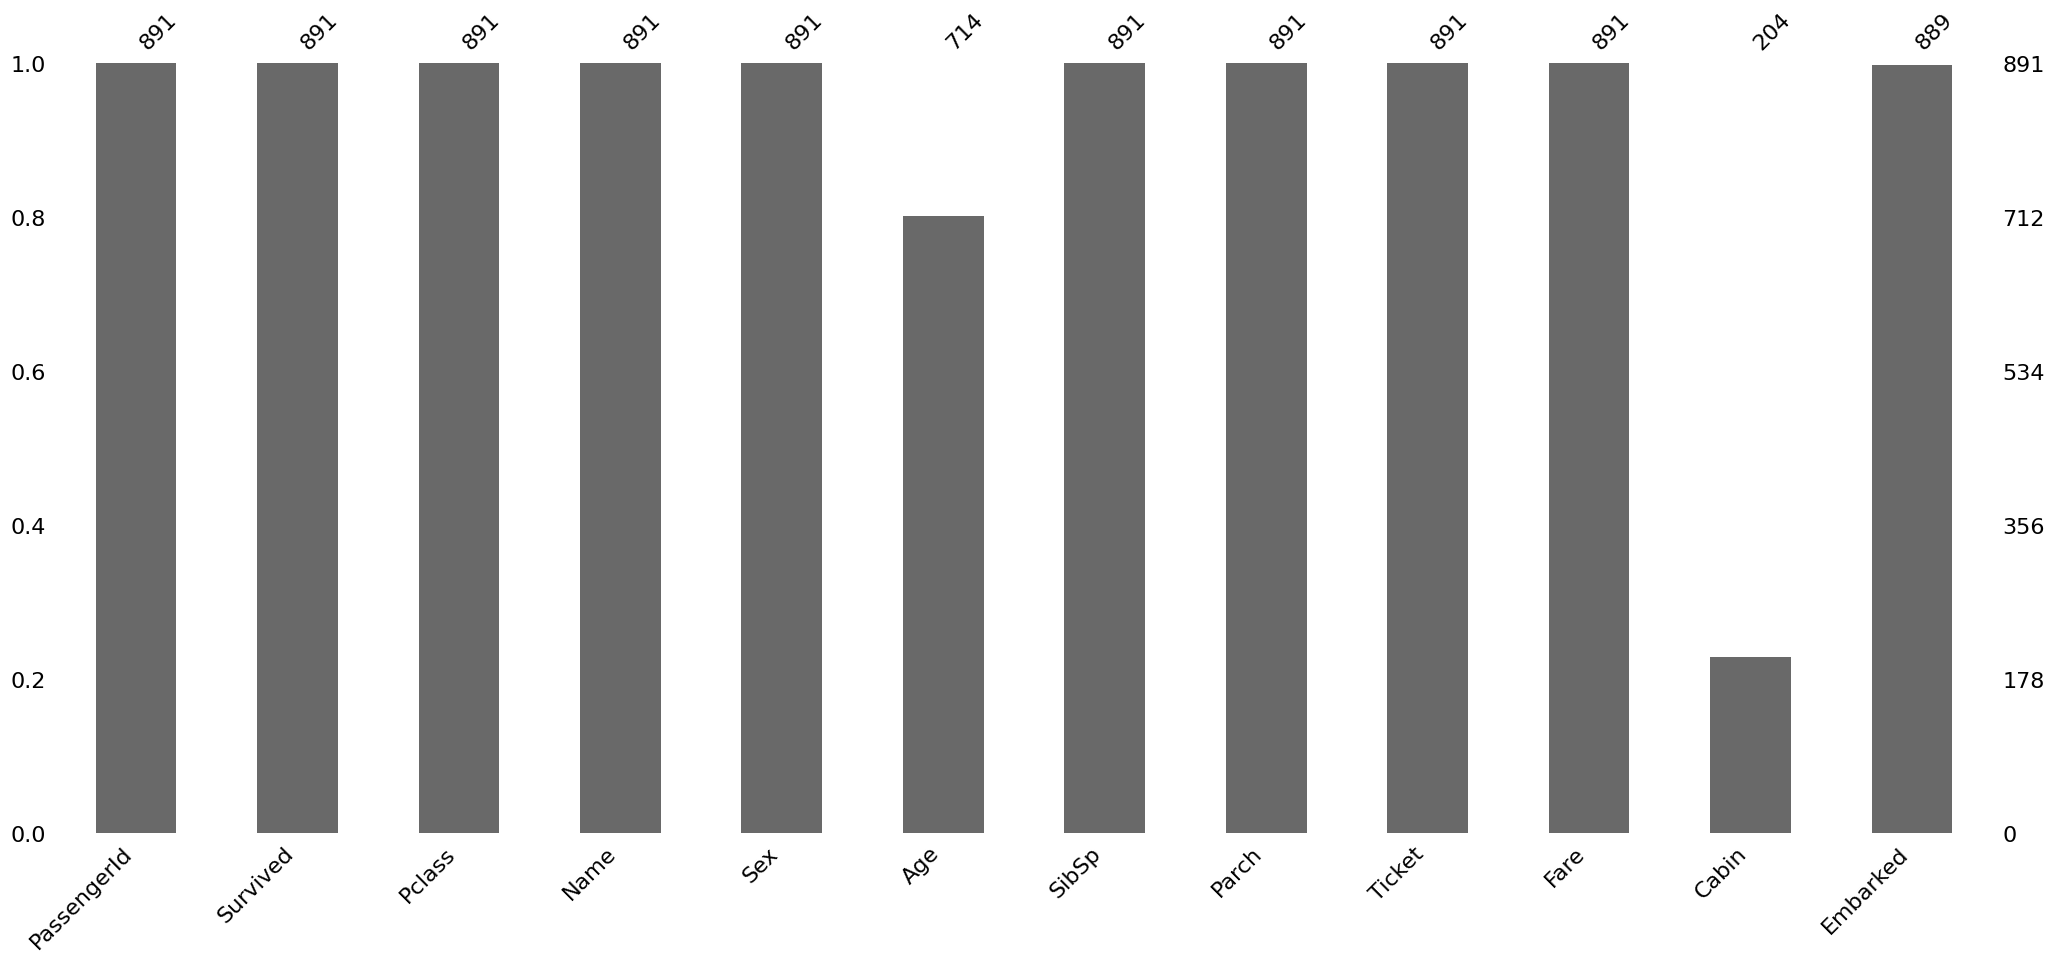

In [103]:
# Смотрим распределение пропусков по признакам
msno.bar(titanic)

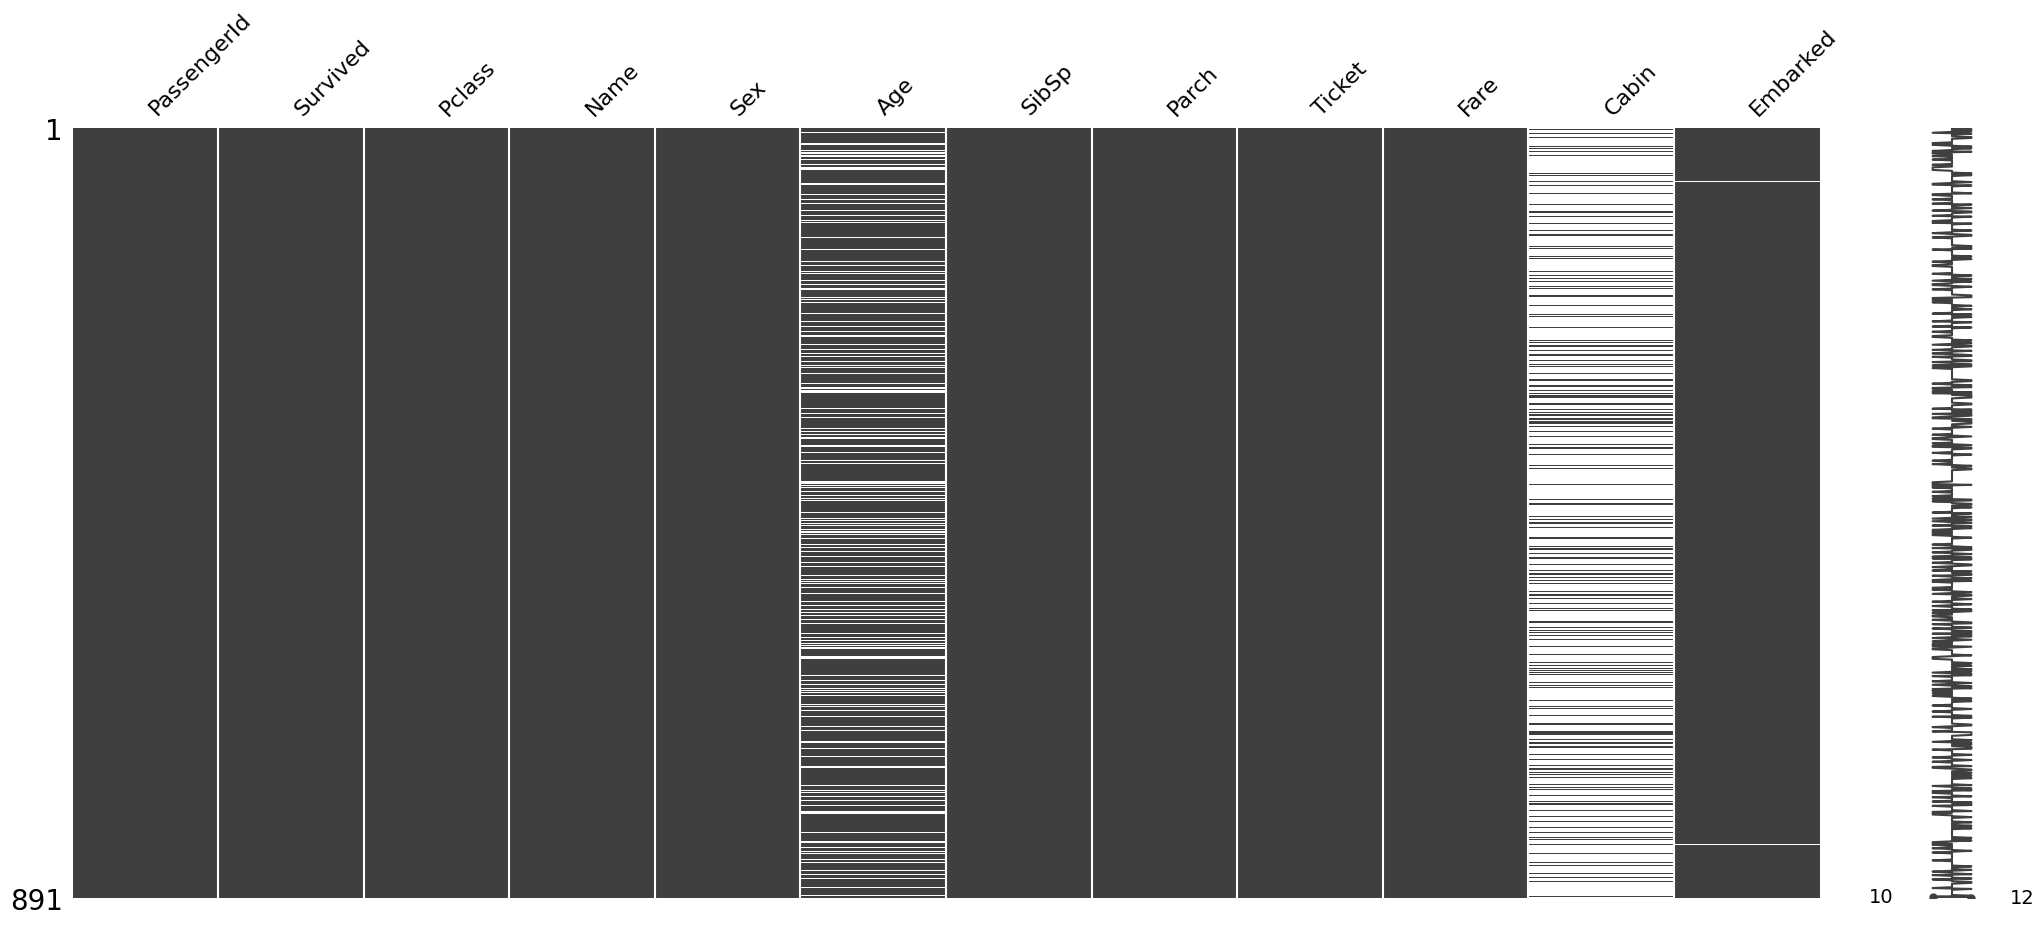

In [104]:
# Эта визуализация, даёт нам более интуитивное представление о том, где отсутствуют значения
msno.matrix(titanic)
plt.show()

In [105]:
# Смотрим типы данных
titanic.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

<Axes: >

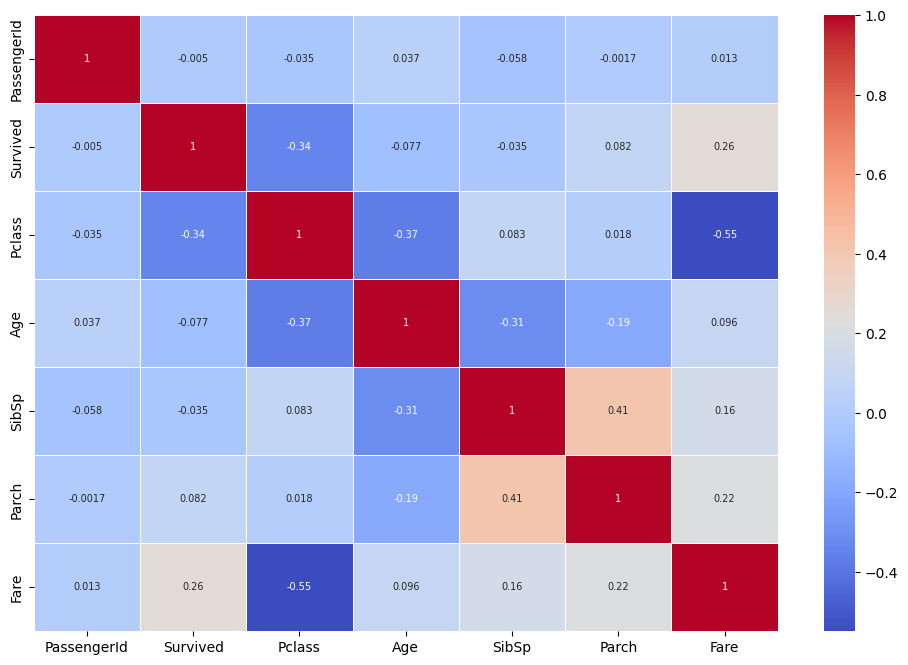

In [106]:
# Выведем корреляционную матрицу между признаками
corr_data = titanic.select_dtypes(include=['float64', 'int64']).corr()  # Выбираем столбцы на основе типа данных

# Задаём размер матрицы
plt.figure(figsize = (12,8))

# Поместим созданную выше корреляционную матрицу в функцию sns.heatmap()
sns.heatmap(corr_data, annot = True, fmt='.2g', annot_kws={'size':str(7)}, linewidths = .5, cmap= 'coolwarm')

In [107]:
# Объединяем признаки с наибольшей корреляцией (Parch и SibSp) в новый признак, называемый family_size
for dataset in [X_train, X_test]:
    dataset['family_size'] = dataset['Parch'] + dataset['SibSp']
    dataset.drop(['Parch', 'SibSp'], axis = 1, inplace = True)
    dataset['is_alone'] = 1
    dataset['is_alone'] = dataset['family_size'].apply(lambda x: 1 if x == 1 else 0)

X_train.head()

,Pclass,Name,Sex,Age,Fare,Embarked,family_size,is_alone
331,1,"Partner, Mr. Austen",male,45.5,28.5000,S,0,0
733,2,"Berriman, Mr. William John",male,23.0,13.0000,S,0,0
382,3,"Tikkanen, Mr. Juho",male,32.0,7.9250,S,0,0
704,3,"Hansen, Mr. Henrik Juul",male,26.0,7.8542,S,1,1
813,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,31.2750,S,6,0


In [108]:
# Извлекаем титулы пассажиров и сохраняем их в новый признак, называемый title
for dataset in [X_train, X_test]:
  dataset['title'] =  dataset['Name'].str.split(", ", expand = True)[1].str.split(".", expand = True)[0]
  dataset.drop(["Name"], axis = 1, inplace = True)

X_train.head()

,Pclass,Sex,Age,Fare,Embarked,family_size,is_alone,title
331,1,male,45.5,28.5000,S,0,0,Mr
733,2,male,23.0,13.0000,S,0,0,Mr
382,3,male,32.0,7.9250,S,0,0,Mr
704,3,male,26.0,7.8542,S,1,1,Mr
813,3,female,6.0,31.2750,S,6,0,Miss


In [109]:
# Смотрим на количество редких титулов. По факту, есть смысл их сгруппировать
X_comb = pd.concat([X_train, X_test])
rare_titles = (X_comb['title'].value_counts() < 10)
rare_titles

title
Mr              False
Miss            False
Mrs             False
Master          False
Dr               True
Rev              True
Col              True
Mlle             True
Major            True
Capt             True
Mme              True
Ms               True
the Countess     True
Lady             True
Don              True
Jonkheer         True
Sir              True
Name: count, dtype: bool

In [110]:
for dataset in [X_train, X_test]:
    dataset['title'] = dataset['title'].replace({'Miss': 'Mrs'})  # Группировка Mrs и Miss в одну группу
    dataset['title'] = dataset['title'].apply(lambda x: 'rare' if rare_titles[x] else x)  # И всех редких в другую

In [111]:
# Проверяем количество титулов
X_comb = pd.concat([X_train, X_test])
rare_titles = (X_comb['title'].value_counts() < 10)
rare_titles

title
Mr        False
Mrs       False
Master    False
rare      False
Name: count, dtype: bool

In [112]:
# Смотрим типы данных
X_train.dtypes

Pclass           int64
Sex             object
Age            float64
Fare           float64
Embarked        object
family_size      int64
is_alone         int64
title           object
dtype: object

In [113]:
# Разделяем признаки по типам данных
cat_cols = ['Embarked', 'Sex', 'Pclass', 'title', 'is_alone']
num_cols = ['Age', 'Fare', 'family_size']

# Функция для заполнения пропусков и кодирования категориальных данных
cat_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False)),
    ('pca', PCA(n_components = 10))  # PCA для уменьшения размерности, после работы OneHotEncoder
])

# Функция для масштабирования числовых данных
num_transformer = Pipeline(steps = [
                          ('imputer', KNNImputer(n_neighbors = 5)),
                          ('scaler', RobustScaler())
])

# Создаём единый трансформер для всех данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

In [114]:
# Строим модель и смотрим результаты CV без настройки гиперпараметров
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

cross_val_score(clf, X_train, y_train, cv = 5, scoring = "accuracy").mean()

0.7935881020388063

In [ ]:
# Выполним поиск гиперпараметров с наивысшим результатом
num_transformer_dist = {'preprocessor__num__imputer__n_neighbors': [3, 5, 8],
                        'preprocessor__num__imputer__add_indicator': [True, False]}

cat_transformer_dist = {'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
                        'preprocessor__cat__imputer__add_indicator': [True, False],
                        'preprocessor__cat__pca__n_components': [3, 6, 10]}

random_forest_dist = {'classifier__n_estimators': [50, 100, 150],
                      'classifier__max_depth': list(range(2, 7)),
                      'classifier__bootstrap': [True, False]}

param_dist = {**num_transformer_dist, **cat_transformer_dist, **random_forest_dist}

# По заданию, нужно работать с GridSearchCV, но на моей машине на это ушло 21мин 40сек
# grid_search = GridSearchCV(clf,
#                             param_grid = param_dist,
#                             cv = 4)

# Работа RandomizedSearchCV на моей машине была выполнена за 1мин 18сек, без значимой потери в результатах
random_search = RandomizedSearchCV(clf,
                                   param_distributions = param_dist,
                                   n_iter = 100)

random_search.fit(X_train, y_train)

In [121]:
# grid_search.best_params_

random_search.best_params_

# Результаты работы GridSearchCV:
# {'classifier__bootstrap': True,
#  'classifier__max_depth': 6,
#  'classifier__n_estimators': 150,
#  'preprocessor__cat__imputer__add_indicator': False,
#  'preprocessor__cat__imputer__strategy': 'constant',
#  'preprocessor__cat__pca__n_components': 3,
#  'preprocessor__num__imputer__add_indicator': False,
#  'preprocessor__num__imputer__n_neighbors': 5}

# Результаты работы RandomizedSearchCV:
# {'preprocessor__num__imputer__n_neighbors': 8,
#  'preprocessor__num__imputer__add_indicator': False,
#  'preprocessor__cat__pca__n_components': 10,
#  'preprocessor__cat__imputer__strategy': 'constant',
#  'preprocessor__cat__imputer__add_indicator': False,
#  'classifier__n_estimators': 150,
#  'classifier__max_depth': 4,
#  'classifier__bootstrap': True}

{'preprocessor__num__imputer__n_neighbors': 8,
 'preprocessor__num__imputer__add_indicator': False,
 'preprocessor__cat__pca__n_components': 10,
 'preprocessor__cat__imputer__strategy': 'constant',
 'preprocessor__cat__imputer__add_indicator': False,
 'classifier__n_estimators': 150,
 'classifier__max_depth': 4,
 'classifier__bootstrap': True}

In [122]:
# y_pred = grid_search.predict(X_test)

y_pred = random_search.predict(X_test)

y_pred[:5]

array([1, 0, 0, 1, 0], dtype=int64)

In [123]:
print(classification_report(y_test, y_pred))

# Результаты с параметрами, определёнными после работы GridSearchCV
#               precision    recall  f1-score   support

#            0       0.80      0.90      0.85       105
#            1       0.82      0.69      0.75        74

#     accuracy                           0.81       179
#    macro avg       0.81      0.79      0.80       179
# weighted avg       0.81      0.81      0.81       179

# Результаты с параметрами, определёнными после работы RandomizedSearchCV
#               precision    recall  f1-score   support

#            0       0.79      0.91      0.85       105
#            1       0.84      0.66      0.74        74

#     accuracy                           0.81       179
#    macro avg       0.82      0.79      0.80       179
# weighted avg       0.81      0.81      0.81       179

              precision    recall  f1-score   support

           0       0.79      0.91      0.85       105
           1       0.84      0.66      0.74        74

    accuracy                           0.81       179
   macro avg       0.82      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179

